In [1]:
import json
from datetime import datetime
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
import sqlite3
import nltk
import spacy
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import umap
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import  cross_val_score
from imblearn.over_sampling import SMOTE
%matplotlib inline
import itertools

In [2]:
df_food = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/df_food_clean.csv')

In [3]:
df_food

,Unnamed: 0,Unnamed: 0.1,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,stars_avg,categories_filtered,food_type,ethnicity,venue,food_comb
0,0,41,98hyK2QEUeI8v2y0AghfZA,Pho Lee's Vietnamese Restaurant,"1541 E 38th St, Ste 101",Cleveland,OH,44114,41.512155,-81.663332,23,1,4,"Restaurants, Vietnamese, Soup",Soup,Vietnamese,Restaurant,"Soup, Vietnamese, Restaurant"
1,1,43,LoRef3ChgZKbxUio-sHgQg,Amir,5252 Rue Jean Talon O,Montréal,QC,H4P 2A7,45.494870,-73.651904,18,1,3,"Restaurants, Lebanese, MiddleEastern",Undefined,"MiddleEastern, Lebanese",Restaurant,"MiddleEastern, Lebanese, Restaurant"
2,2,63,ZkzutF0P_u0C0yTulwaHkA,Lelulos Pizzeria,311 Unity Center Rd,Plum,PA,15239,40.489996,-79.779288,31,1,4,"Restaurants, Pizza",Pizza,Undefined,Restaurant,"Pizza, Restaurant"
3,3,73,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,Toronto,ON,M4M 1Y3,43.666376,-79.348773,116,1,4,"Vietnamese, Restaurants",Undefined,Vietnamese,Restaurant,"Vietnamese, Restaurant"
4,4,83,7j0kor_fkeYhyEpXh4OpnQ,Scramblers - Strongsville,16726 Pearl Rd,Strongsville,OH,44136,41.295689,-81.835722,81,1,3,"Breakfast&Brunch, Restaurants, American(Tradit...","Breakfast&Brunch, Salad",American(Traditional),Restaurant,"Breakfast&Brunch, Salad, American(Traditional)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30539,30539,209376,cmsAFAymfVoBitSF8R6GKw,Yao Fine Chinese Cuisine,"2487 S Gilbert Rd, Ste 102",Gilbert,AZ,85295,33.304935,-111.788861,230,1,4,"Chinese, Restaurants",Undefined,Chinese,Restaurant,"Chinese, Restaurant"
30540,30540,209377,n2BKYb8aw4AhRKLkdUjQRg,Steak & Cheese & Quick Pita Restaurant,199 College St,Toronto,ON,M5T 1P9,43.658683,-79.395071,21,1,3,"Sandwiches, Restaurants",Sandwiches,Undefined,Restaurant,"Sandwiches, Restaurant"
30541,30541,209380,YZeUH6zYS0dq5QHLYZhUnQ,Hooters,2820 N 75th Ave,Phoenix,AZ,85035,33.479139,-112.221142,106,1,2,"Nightlife, American(Traditional), ChickenWings...",ChickenWings,American(Traditional),Restaurant,"ChickenWings, American(Traditional), Restaurant"
30542,30542,209385,hskVqZCPqy-omm9CHi44xQ,Domino's,"6420 Rea Rd, Suite B1",Charlotte,NC,28226,35.078538,-80.818358,16,1,1,"Restaurants, Pizza, Sandwiches, FastFood, Chic...","ChickenWings, FastFood, Pizza, Sandwiches",Undefined,Restaurant,"ChickenWings, FastFood, Pizza, Sandwiches, Re..."


In [4]:
df_food['stars_avg'].replace(3,np.nan, inplace =True)
df_food.dropna(inplace=True)
df_food['star_binary'] = np.where(df_food['stars_avg'] <3, 'no', 'yes')


In [5]:
df_food['state_star'] = df_food['state'] + df_food['star_binary']


In [6]:
df_food_v2 = df_food.reset_index(drop=True).drop('Unnamed: 0', axis = 1)

In [7]:
df_food_clean = df_food_v2.copy()

In [19]:
df_food_clean = df_food_v2.loc[df_food_v2['state_star'].str.contains('yes')].reset_index(drop=True)

In [20]:
vectorizer = CountVectorizer(analyzer='word', min_df=50)
Xvec = vectorizer.fit_transform(df_food_clean['food_comb'])
bow_df = pd.DataFrame(Xvec.toarray(), columns=vectorizer.get_feature_names())

In [21]:
vectorizertf = TfidfVectorizer(analyzer='word', min_df=50, max_features=50)
Xvectf = vectorizertf.fit_transform(df_food_clean['food_comb'])
tf_df = pd.DataFrame(Xvectf.toarray(), columns=vectorizertf.get_feature_names())

In [22]:
state_dummies = pd.get_dummies(df_food_clean['state'], drop_first = True)

In [23]:
df_vec = bow_df

In [24]:
df_vec = tf_df

In [25]:
X = df_vec
y = df_food_clean['state']

In [26]:
k = 25
if len(X.columns) >= k:
    skb = SelectKBest(k = k, score_func = f_classif)
    best_kfit = skb.fit(X, y)
    X_best_feat = best_kfit.fit_transform(X,y)

    X_best_feat = pd.DataFrame(X_best_feat, columns=X.columns[best_kfit.get_support()])

    best_features = X_best_feat.columns.tolist()
else:
    print('To few columns to select')

In [27]:
best_features

['american',
 'breakfast',
 'brunch',
 'cafes',
 'chickenwings',
 'delis',
 'diners',
 'fastfood',
 'french',
 'indian',
 'japanese',
 'juicebars',
 'korean',
 'mexican',
 'middleeastern',
 'new',
 'pizza',
 'restaurant',
 'salad',
 'sandwiches',
 'seafood',
 'smoothies',
 'steakhouses',
 'traditional',
 'vietnamese']

In [28]:
# X = df_vec[best_features]
# y = df_food_clean['state']

In [29]:
X

,american,asianfusion,bakeries,barbeque,breakfast,brunch,burgers,cafes,chickenwings,chinese,...,specialtyfood,steakhouses,sushibars,tapas,tea,thai,traditional,vegan,vegetarian,vietnamese
0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.678644
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
2,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.954158
3,0.307134,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.361777,0.0,0.00000,0.000000
4,0.361767,0.0,0.0,0.0,0.412978,0.412978,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.416195,0.0,0.426129,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17260,0.000000,0.0,0.0,0.0,0.669834,0.669834,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
17261,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.41247,0.000000
17262,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
17263,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.707107,0.0,0.000000,0.0,0.00000,0.000000


In [30]:
le_train = LabelEncoder()
y_le = le_train.fit_transform(y)

In [31]:
y.value_counts()

ON    4122
AZ    3887
NV    2792
OH    1859
QC    1678
NC    1516
PA    1411
Name: state, dtype: int64

In [37]:
y_state_dict= pd.concat([pd.DataFrame(y_le), pd.DataFrame(y)], axis = 1).groupby('state')[0].mean()

In [38]:
y_state_dict_swap = {value:key for key, value in y_state_dict.items()}
labels = list(y_state_dict_swap.values())

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y_le, stratify = y_le, random_state = 42)

In [68]:
y_export = pd.Series(y_le)
X.to_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/C4_bus_state_X.csv')
y.to_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/C4_bus_state_y.csv')

In [70]:
y.shape

(17265,)

In [41]:

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [42]:

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:

lr1 = LogisticRegression()
thresholds = [x for x in np.arange(.01,1,.01)]
c_values = [10**x for x in range(-3,2)]
params = {'solver':['liblinear','lbfgs'], 'C':c_values, 'penalty':['l2'], 'max_iter': [10000]}

gslr1 = GridSearchCV(lr1, params)
gslr1.fit(X_train_scaled, y_train)


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [10000],
                         'penalty': ['l2'], 'solver': ['liblinear', 'lbfgs']})

In [44]:
y_test_pred = gslr1.predict(X_test_scaled)
y_train_pred = gslr1.predict(X_train_scaled)

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,log_loss, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
print('LR1 confusion matrix')
#lr1train = confusion_matrix(y_train, y_pred_train, normalize= None)
lr1test = confusion_matrix(y_test, y_test_pred, normalize = None)
lrdata = pd.DataFrame(lr1test).rename(columns = y_state_dict_swap, index = y_state_dict_swap)


LR1 confusion matrix


In [46]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=10)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=10)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

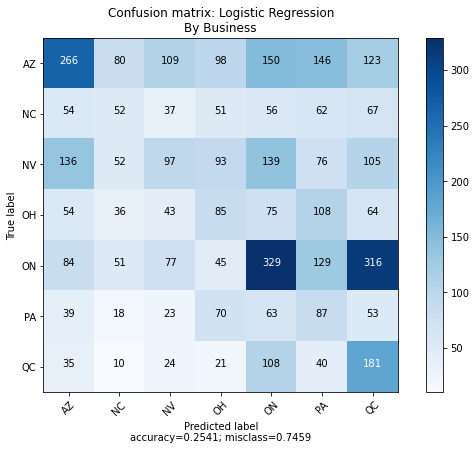

In [47]:
target_names = labels 
plot_confusion_matrix(lr1test,
                          target_names,
                          title='Confusion matrix: Logistic Regression\nBy Business',
                          cmap=None,
                          normalize=None)

In [48]:
print('Test macro average recall score is ',recall_score(y_test, y_test_pred, average = 'macro').round(3))
print('Train macro average recall score is ',recall_score(y_train, y_train_pred, average = 'macro').round(3))

Test macro average recall score is  0.247
Train macro average recall score is  0.274


In [49]:
print('Test accuracy score is ',accuracy_score(y_test, y_test_pred))
print('Train accuracy score is ',accuracy_score(y_train, y_train_pred))

Test accuracy score is  0.2541116516099143
Train accuracy score is  0.2742062208254379


In [50]:
recall_score(y_test, y_test_pred, average = 'macro')/(1/lr1test.shape[0])

1.730177390864948

In [51]:
# knn1 = KNeighborsClassifier(n_neighbors=15, weights='uniform', leaf_size=20)
# knn1.fit(X_train_scaled, y_train)

# y_test_predknn1 = knn1.predict(X_test_scaled)
# y_train_predknn1 = knn1.predict(X_train_scaled)
# print('Test macro average recall score is ',recall_score(y_test, y_test_predknn1,average = 'macro'))
# print('Train macro average recall score is ',recall_score(y_train, y_train_predknn1,average = 'macro'))

In [52]:
# knntest = confusion_matrix(y_test, y_test_pred, normalize = None)
# dfknn = pd.DataFrame(knntest).rename(columns = y_state_dict_swap)

In [53]:
# print('Test accuracy score is ',accuracy_score(y_test, y_test_predknn1))
# print('Train accuracy score is ',accuracy_score(y_train, y_train_predknn1))

In [54]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
y_test_predrf = rf.predict(X_test_scaled)
y_train_predrf = rf.predict(X_train_scaled)
thresholds = [x for x in np.arange(.01,1,.01)]
c_values = [10**x for x in range(-3,2)]
params = { 'max_depth': [5, 10],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'n_estimators': [100, 1000]}

gsrf = GridSearchCV(rf, params)
gsrf.fit(X_train_scaled, y_train)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 1000]})

In [55]:
y_test_predrf = rf.predict(X_test_scaled)
y_train_predrf = rf.predict(X_train_scaled)

print('Train macro average recall score is ',recall_score(y_train, y_train_predrf,average = 'macro').round(3))
print('Test macro average recall score is ',recall_score(y_test, y_test_predrf,average = 'macro').round(3))

Train macro average recall score is  0.538
Test macro average recall score is  0.246


In [56]:
rftest = confusion_matrix(y_test, y_test_predrf, normalize = None)
dfrf = pd.DataFrame(rftest).rename(columns = y_state_dict_swap)

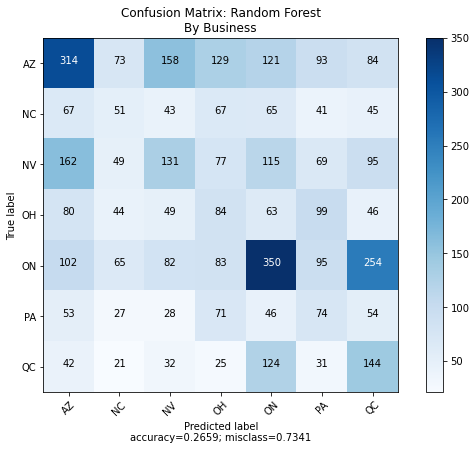

In [57]:

plot_confusion_matrix(rftest,target_names,'Confusion Matrix: Random Forest\nBy Business')

In [58]:
(recall_score(y_test, y_test_predrf, average = 'macro')/(1/rftest.shape[0])).round(3)

1.719

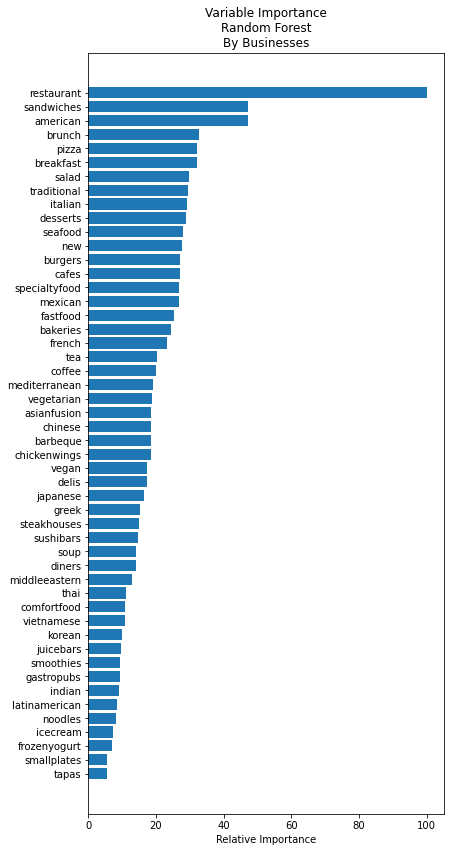

In [59]:
feature_importance = rf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (14,14))

plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance\nRandom Forest\nBy Businesses')
plt.show()

In [60]:
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance', 
          'learning_rate':0.08, 
          'subsample':.62, 
          'min_samples_split':.02}

# Initialize and fit the model.
gbc = GradientBoostingClassifier(**params)
gbc.fit(X_train_scaled, y_train)

y_test_predgb = gbc.predict(X_test_scaled)
y_train_predgb = gbc.predict(X_train_scaled)

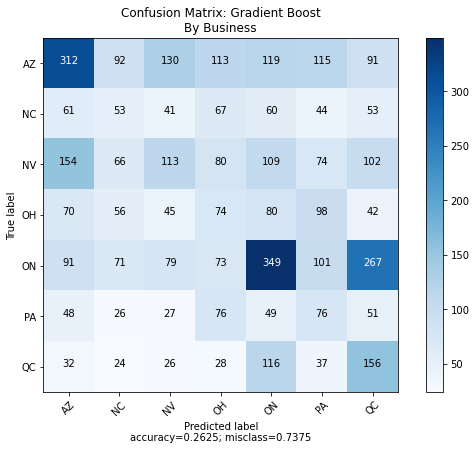

In [61]:
gbtest = confusion_matrix(y_test, y_test_predgb)
plot_confusion_matrix(gbtest,target_names,'Confusion Matrix: Gradient Boost\nBy Business')

In [62]:
print('Test macro average recall score is ',recall_score(y_test, y_test_predgb,average = 'macro').round(3))
print('Train macro average recall score is ',recall_score(y_train, y_train_predgb,average = 'macro').round(3))

Test macro average recall score is  0.244
Train macro average recall score is  0.403


In [63]:
recall_score(y_test, y_test_pred, average = 'macro')/(1/gbtest.shape[0])

1.730177390864948

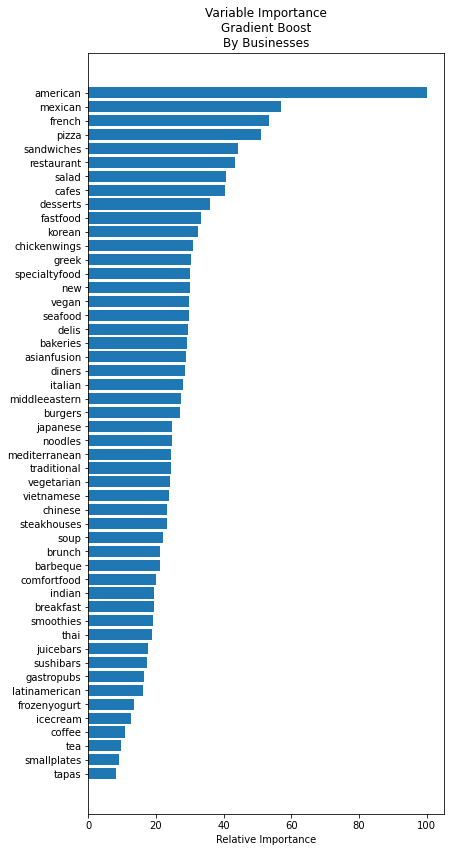

In [64]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (14,14))

plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance\nGradient Boost\nBy Businesses')
plt.show()